# Exercise 2  - Computational Geomechanics 2024-2025

The goal of this exercise is to solve the problem of porous media flow around a sheet pile wall. in other words, we want to solve Darcy's equation ($q_i = - k h_{,i}$) with imposed boundary conditions. 

In a first step we will assume a soil with homogeneous permeability. We will later relax this assumption and interpret the effects of a variable permeability.

#### External libraries

We will use `python` and it's many computing libraries to do finite element computations. Here are some of the libraries we will use:

- `numpy` stands for *numerical python* and is the main library used, along with `scipy`, for scientific computing. You can access the documentation [here](https://numpy.org/doc/stable/).
- `matplotlib` is a library used for plotting purposes. The documentation is accessible [here](https://matplotlib.org/stable/index.html).
- `pygmsh` is a python wrapper for the mesh generator `gmsh`. We will generate meshes with this library and manipulate it's output with our own code. You can access `pygmsh` documentation at the following [link](https://pygmsh.readthedocs.io/en/latest/index.html).

In [1]:
# importing the necessary python modules
# numpy and matplotlib are popular packages for scientific computing and plotting
import numpy as np
import matplotlib.pyplot as plt
import pygmsh

# interactive python (iPython) magic to instruct jupyter how to show the plots with respect to the code cells
%matplotlib inline

# various plotting parameters
plt.rcParams['text.usetex'] = False
plt.rcParams['axes.labelsize'] = 12

# scipy is an extension for numpy, used extensively in scientific computing
import scipy as sp

#### Internal functions

We will use some internal functions that we are coding up during this course. For the solution of this problem we require the following moduls and sources

- `Mesh` stands for *mesh object* and contains all relevant information on the mesh we will create. See Exercice 1 for more detailed explanations. It has some utilities to perform on the Mesh which are stored in `MeshUtils`. 
- `MatrixAssembly` is our file where all the relevant functions can be found to assemble matrices
- `PoroElasticProperties` refers to a library allowing us to transform poroelastic properties from one to another.

In [122]:
# The following lines are though to import the source functions
import sys
sys.path.append('../src/')

# And we import the necessary tools from our source folder.
from MesherWrapper import Mesh
from MeshUtils import MeshUtils
import MatrixAssembly
import PoroElasticProperties as prop

## 1. Generating the Mesh

We first generate the mesh according to the dimensions given in section 1 of the exercises.

(5.999998, 6.000002)

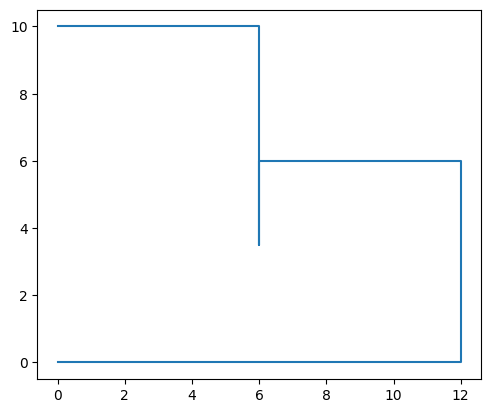

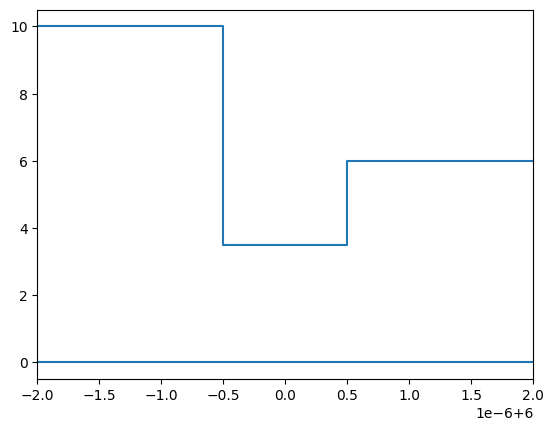

In [123]:
# We define the different dimensions of the problem 
D = 10
H = 4
s = 6
b = 6
t = 2.5

# As to get a mesh that is conform, we need to introduce a very small width of our wall
twall = 1e-6

# we can now define the vertices using the dimensions. We start from the left bottom and place it at [0, 0] and then go anti-clockwise
vertices = np.array([[0, 0],
                     [s + b + twall, 0],
                     [s + b + twall, D - H],
                     [s + twall/2, D - H],
                     [s + twall/2, D - H - t],
                     [s - twall/2, D - H - t],
                     [s - twall/2, D],
                     [0, D]])

# We simply inspect how the boundaries look like
plt.figure()
plt.plot(vertices[:, 0], vertices[:, 1])
plt.gca().set_aspect(1)
# Note that the bottom is not closed when plotting in this manner. This is because for the meshing we will not repeat a vertex.

# To see the separation caused by the wall we need to zoom in closer
plt.figure()
plt.plot(vertices[:, 0], vertices[:, 1])
plt.xlim(s - 2*twall, s + 2*twall)

#### Resolution

We now generate the mesh with a vertice with the resolution imposed. You are asked to compare to the graphical exact solution provided in figure 2 of the PDF. To get closer to this solution, you can notably adjust the resolution.

Text(0, 0.5, 'y (m)')

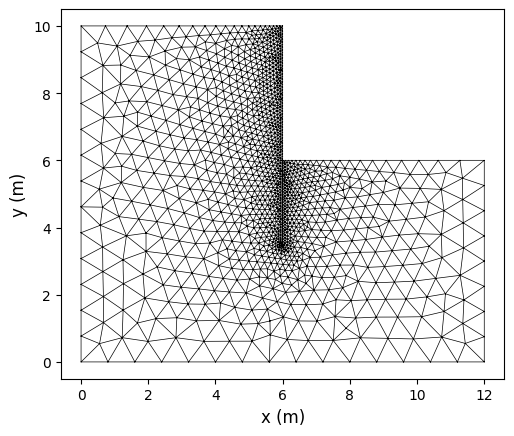

In [124]:
# we create a mesh with triangle finite elements with the pygmsh library.

# we can have a per point cell resolution, telling pygmsh where we want finer elements
# there are multiple ways to do this, but a simple one is to make a list as long as our points as seen in the end of the previous exercise (complete below).
# resolutions = np.array()
resolutions = np.array([0.1, 0.1, 0.1, 0.01, 0.01, 0.01, 0.01, 0.1])*8

with pygmsh.geo.Geometry() as geom:
    # we initiate an empty line list
    lines = []

    # we instantiate points p1 and p2 and make sure to store the first one in p0
    p1 = p0 = geom.add_point(vertices[0], resolutions[0])

    # at every iteration, we make a line going from p1 to p2
    for i in range(len(vertices) - 1):
        p2 = geom.add_point(vertices[i + 1], resolutions[i + 1])
        line = geom.add_line(p1, p2)
        lines.append(line)
        p1 = p2  # we make sure that p1 becomes p2, the next point to be in lines

    # we add the last line, closing the loop with p2 to p0
    lines.append(geom.add_line(p2, p0))

    # curve loop is a collection of lines where every endpoints are connected
    loop = geom.add_curve_loop(lines)  

    # the plane surface is the area that is going to be partitionned in finite elements
    surf = geom.add_plane_surface(loop)

    # final command to do the computations
    out = geom.generate_mesh()

# we pass it to our wrapper object 'Mesh' with which we'll be interacting through our computations
mesh = Mesh(out)

# we can use the mesh.plot() function to easily show it

fig, ax = mesh.plot()
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')

## 2. Uniform permeability

We consider first the case of a uniform permeability. such that our next step is to define the boundary conditions

### Defining the boundary conditions

To properly define the different boundary conditions of our problems, we need to have a map to the different nodes. In this problem, we will need to impose different boundary conditions at

- the impermeable sheet pile wall,
- the phreatic surface on the left side of the wall,
- the phreatic surface at the right side of the wall and
- the other boundaries (left, bottom and right edges).

We can access those nodes with `mesh.nodes`, of size `(number of nodes, 2)` and using conditional indexing. 

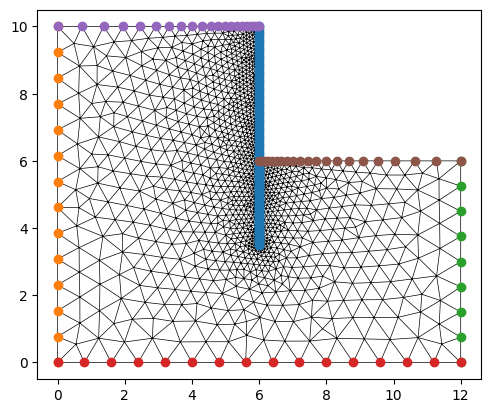

In [125]:
# We first search for the nodes which are on the sheet pile wall.
# Note that the vertical line | is equivalent to an 'or' condition and the & sign to a 'and' condition
sheet_pile = np.argwhere((mesh.nodes[:, 0] == (s - twall/2)) | (mesh.nodes[:, 0] == (s + twall/2)) & (mesh.nodes[:, 1] >= D - H - t))[:, 0]

# Here we are looking for the boundaries on the left, right, and bottom with natural boundary conditions.
# complete the code below
left = np.argwhere(mesh.nodes[:, 0] == 0)[:, 0]
right = np.argwhere(mesh.nodes[:, 0] == s + b + twall)[:, 0]
bottom = np.argwhere(mesh.nodes[:, 1] == 0)[:, 0]

# Finally, we have to get ground surface and the surface inside the trench
# complete the code below
ground_surface = np.argwhere(mesh.nodes[:, 1] == D)[:, 0]
trench_surface = np.argwhere((mesh.nodes[:, 1] == D - H) & (s + twall/2 <= mesh.nodes[:, 0]))[:, 0]


# The following is a way to visualize your different boundaries. Note that nodes on the edges belong to two boundaries and simply overwrite.
# You should obtain the following color code. 
# - sheet pile wall --> light blue
# - left --> orange
# - right --> green
# - bottom --> red
# - ground surface --> purple
# - trench surface --> brown
mesh.plot()

for condition in (sheet_pile, left, right, bottom, ground_surface, trench_surface):
    plt.scatter(*mesh.nodes[condition].T)

Once we have selected the points correctly, we can now assign the respective boundary conditions to them.

In [126]:
# We first initiate a head vector. Which will be the solution to the problem everywhere in the system. For now lets fill it with zeros.
head = np.zeros((mesh.number_nodes, 1))

# Now we set the piezometric head (recall that Darcy's flow is in term of the head) at the ground surface and at the trench surface
# complete the following
# head[...] =               # at the ground surface 
# head[...] =               # at the trench surface 
head[ground_surface] = D
head[trench_surface] = D - H

# The nodes where the head is fixed by the boundary condition are our fixed nodes. We define them here by combining (hstack is horizontally stacking arrays)
# the boundary of the ground_sourface and the trench_surface. 
fixed_nodes = np.hstack((ground_surface, trench_surface))

# The remaining nodes are where we do not know the head (setdiff1d takes the difference between two arrays). We generate a vector of all numbers
# of nodes we have (np.arange does this) and take the ones which are not in fixed_nodes.
unknown_nodes = np.setdiff1d(np.arange(mesh.number_nodes), fixed_nodes)

# We print their shapes and observe the difference. Note that their sume is the total number of nodes.
print(f'The number of fixed nodes is {len(fixed_nodes)}')
print(f'The number of unknown nodes is {len(unknown_nodes)}')
print(f'The total number of nodes is {mesh.number_nodes}')

The number of fixed nodes is 42
The number of unknown nodes is 1317
The total number of nodes is 1359


#### Question
Note that we did not do anything with the other boundaries. Can you explain why?

#### Answer

Natural boundary conditions impose a zero flow condition. This is the natural condition because it is natural in the system and does not require any treatment from our side. Hence, the boundaries left, right, and bottom need no treatment. Finally, an impermeable wall is nothing else than a natural boundary condition, which is why also this boundary needs no treatment.

### Assembly of the conductivity matrix

In the next step we will use the loaded package `MatrixAssembly` to create the conductivity matrix. For now, we use a uniform permeability.

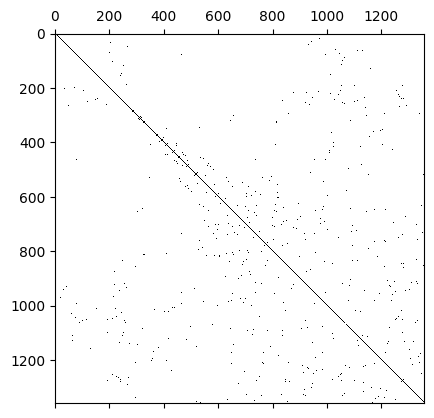

In [127]:
# We define the permeability and use the function to assemble the matrix
permeability = 1
C = MatrixAssembly.assemble_conductivity_matrix(mesh, permeability)

# We can now inspect the matrix to see where we have non-zero entries.
plt.spy(C.todense())

### Solving the system of equations

We only have natural boundary conditions of the Neumann type which need no treatment (e.g., our force vector has no non-zero entry). However, the non-zero dirichlet boundary conditions for head need to be transformed into a force vector (see course notes). 

In [128]:
# We initialize the force vector
f = np.zeros((mesh.number_nodes, 1))
# In the next step we seperate the conductivity matrix into its parts. notably we are interested in the parts relating the fixed to the unknowon nodes (C_fixed)
# and the part relating the unknown to the unknown nodes (C_unknown).
# complete the code below

C_fixed = C[unknown_nodes][:, fixed_nodes]
C_unknown = C[unknown_nodes][:, unknown_nodes]

# With this parts of the matrix at hand, we can now get the unknown components of the force vector given by the imposed non-zero Dirichlet conditions
# complete the code below
f_fixed = -C_fixed.dot(head[fixed_nodes])

# We then add the components of the fixed force vector to the general force vector
f[unknown_nodes] += f_fixed

# With the correct force vector we can now simply solve the system
#complete the code below
head_unknown = sp.sparse.linalg.spsolve(C_unknown, f_fixed)

# And finally glue the solution back together
head[unknown_nodes] = head_unknown.reshape((len(unknown_nodes), 1))

### Plotting the results
We can look at the distribution of the head across our imaginary sheet pile. We are also interested in the fluxes and it's magnitude. You can use the `project_flux` function programmed in the last exercice to get those.

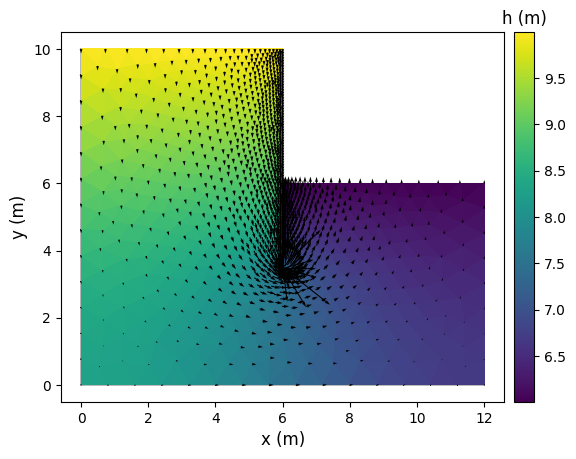

In [129]:
# Define the figure axes and background
fig, ax, cb = mesh.plot(head[:, 0], shading='flat')

# label the axes and the color code
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
cb.ax.set_title('h (m)')

# We now run the code of last week to get the fluxes
qx, qy = MatrixAssembly.project_flux(mesh, permeability, head)

# And add the flow as arrows
ax.quiver(mesh.nodes[:, 0], mesh.nodes[:, 1], qx, qy)

### Comparison to graphical exact solution

As said in the introduction to the exercise. It is now possible to calculate the the exit gradient and compare it to the graphical solution.

In [130]:
# We first find the exit node
# complete the code below

exitnode = np.argwhere((mesh.nodes[:, 0] == (s + twall / 2)) & (mesh.nodes[:, 1] == (D - H)))[:, 0]

# Before we can get the vertical flux at this location
# complete the code below
exit_gradient = qy[exitnode]

# And we print the solution
print(f'The numerical exit gradient is {exit_gradient[0]}')

The numerical exit gradient is 0.3762461885003235


We now calculate the difference to the estimated gradient. For the configuration studied herein (case 1) we have:
- $\delta = t / H = 0.625$ $\rightarrow$ Curve I
- $I_E t / H \approx 0.255$ $\rightarrow$ $I_E \approx 0.4088$

In [131]:
I_E_analytical = 0.4088

# such that the relative error is
rel_err = abs(1 - exit_gradient/I_E_analytical) * 100
print(f'The relative error on the gradient is {rel_err[0]} %')


The relative error on the gradient is 7.963261130057853 %


### Different resolutions and second case

We will let you now reuse the code above to perform different simulations with finer/coarser meshes and study the convergence of this and the two cases.

## 3. Layers of different permeability

You can re-use all ingredients from before apart from the ones which depend on the conductivity. Most likely, the actual soil will not consist of a single layer, but will have different conductivities.

The implementation of such different materials is straightforward and is performed using the material ID (`Mesh.id`) assigned to every element in our mesh. The corresponding array is automatically created upon the creation of the mesh and assigns an ID of 0 to all elements (e.g., all elements are of the same type). Let us now add a second soil type from a height of $y = 2$ m on downwards.

To do so, we assign a different material index (ID) to all elements whose barycenters lay in the lower layer.

In [132]:
# We loop over all the elements and extract their barycenter. If it fulfils the condition we assign the material ID 1 to it.
for e in range(mesh.number_els):
    barycenter = MeshUtils.getBarycenter(mesh, e)
    # complete the condition
    if  barycenter[1] <= 2:
        mesh.id[e] = 1

The only part of our calculation affected by the different conductivity is the conductivity matrix. We thus reassemble it using the two permeabilities.

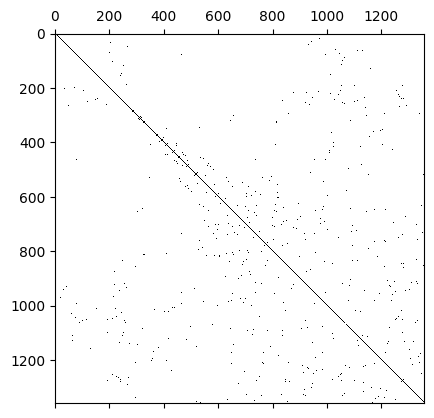

In [133]:
# elements with material ID 1, will get lower permeability value
permeability = [1, 0.1] # The vector of the permeability must have as many entries as you have unique values of the ID.
C = MatrixAssembly.assemble_conductivity_matrix(mesh, permeability)

plt.spy(C.todense())

And we can solve and visualize the system in the exact same way as before.

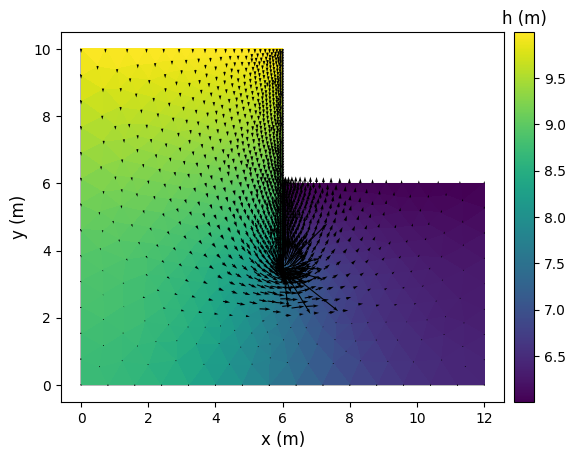

In [134]:
# We initialize the force vector
f = np.zeros((mesh.number_nodes, 1))

# In the next step we seperate the conductivity matrix into its parts. notably we are interested in the parts relating the fixed to the unknowon nodes (C_fixed)
# and the part relating the unknown to the unknown nodes (C_unknown).
# complete the code below

C_fixed = C[unknown_nodes][:, fixed_nodes]
C_unknown = C[unknown_nodes][:, unknown_nodes]

# With this parts of the matrix at hand, we can now get the unknown components of the force vector given by the imposed non-zero Dirichlet conditions
# complete the code below
f_fixed = -C_fixed.dot(head[fixed_nodes])

# We then add the components of the fixed force vector to the general force vector
f[unknown_nodes] += f_fixed

# With the correct force vector we can now simply solve the system
#complete the code below
head_unknown = sp.sparse.linalg.spsolve(C_unknown, f_fixed)

# And finally glue the solution back together
head[unknown_nodes] = head_unknown.reshape((len(unknown_nodes), 1))

# Define the figure axes and background
fig, ax, cb = mesh.plot(head[:, 0], shading='flat')

# label the axes and the color code
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
cb.ax.set_title('h (m)')

# We now run the code of last week to get the fluxes
qx, qy = MatrixAssembly.project_flux(mesh, permeability, head)

# And add the flow as arrows
ax.quiver(mesh.nodes[:, 0], mesh.nodes[:, 1], qx, qy)

You can now play around with different number and types of soils and see what happens to the hydraulic head and the flow.

### Refinement of the interface

It is clear that simply changing the ID does not clearly delimit the two parts. We contour this problem here by adding a number of points at the interface ensuring that we accurately model the limit.

Text(0, 0.5, 'y (m)')

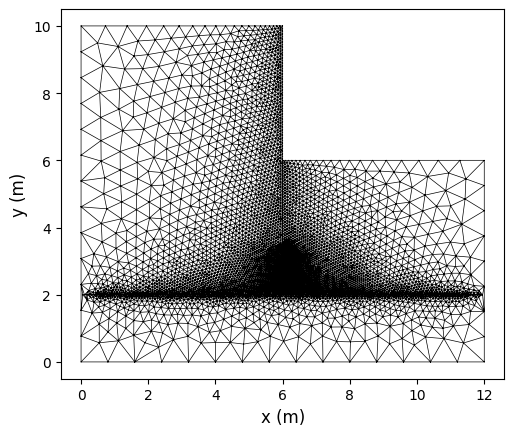

In [135]:
# We define the vertices of the internal boundary
hl = 2
spacing = 0.05
points_internal = np.linspace(spacing, s + b + twall - spacing, int((s + b + twall - 2 * spacing)/spacing))

with pygmsh.geo.Geometry() as geom:
    # we initiate an empty line list
    lines = []

    # we instantiate points p1 and p2 and make sure to store the first one in p0
    p1 = p0 = geom.add_point(vertices[0], resolutions[0])

    # at every iteration, we make a line going from p1 to p2
    for i in range(len(vertices) - 1):
        p2 = geom.add_point(vertices[i + 1], resolutions[i + 1])
        line = geom.add_line(p1, p2)
        lines.append(line)
        p1 = p2  # we make sure that p1 becomes p2, the next point to be in lines

    # we add the last line, closing the loop with p2 to p0
    lines.append(geom.add_line(p2, p0))

    # curve loop is a collection of lines where every endpoints are connected
    loop = geom.add_curve_loop(lines)  

    # the plane surface is the area that is going to be partitionned in finite elements
    surf = geom.add_plane_surface(loop)

    # here we add a line of internal points
    for i in range(len(points_internal) ):
        p = geom.add_point([points_internal[i], hl], spacing)
        geom.in_surface(p, surf)

    # # We add the points to the surface
    # geom.in_surface(np.vstack((points_internal, hl * np.ones(len(points_internal)))), surf)

    # final command to do the computations
    out = geom.generate_mesh()

# we pass it to our wrapper object 'Mesh' with which we'll be interacting through our computations
mesh = Mesh(out)

# we can use the mesh.plot() function to easily show it

fig, ax = mesh.plot()
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')

We solve the problem again in the exact same manner.

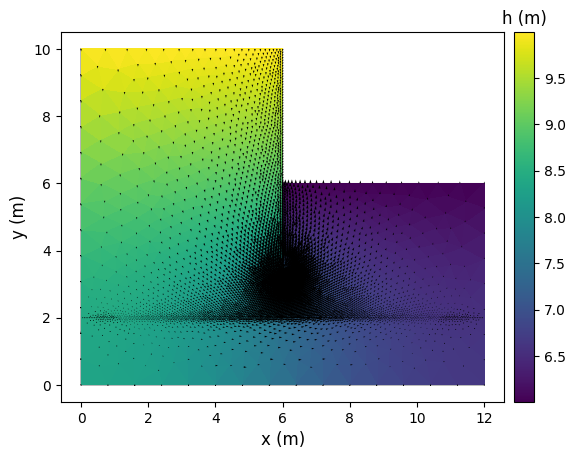

In [136]:
# We first search for the nodes which are on the sheet pile wall.
# Note that the vertical line | is equivalent to an 'or' condition and the & sign to a 'and' condition
sheet_pile = np.argwhere((mesh.nodes[:, 0] == (s - twall/2)) | (mesh.nodes[:, 0] == (s + twall/2)) & (mesh.nodes[:, 1] >= D - H - t))[:, 0]

# Here we are looking for the boundaries on the left, right, and bottom with natural boundary conditions.
left = np.argwhere(mesh.nodes[:, 0] == 0)[:, 0]
right = np.argwhere(mesh.nodes[:, 0] == s + b + twall)[:, 0]
bottom = np.argwhere(mesh.nodes[:, 1] == 0)[:, 0]

# Finally, we have to get ground surface and the surface inside the trench
ground_surface = np.argwhere(mesh.nodes[:, 1] == D)[:, 0]
trench_surface = np.argwhere((mesh.nodes[:, 1] == D - H) & (s + twall/2 <= mesh.nodes[:, 0]))[:, 0]

# We first initiate a head vector. Which will be the solution to the problem everywhere in the system. For now lets fill it with zeros.
head = np.zeros((mesh.number_nodes, 1))

# Now we set the piezometric head (recall that Darcy's flow is in term of the head) at the ground surface and at the trench surface
head[ground_surface] = D
head[trench_surface] = D - H

# The nodes where the head is fixed by the boundary condition are our fixed nodes. We define them here by combining (hstack is horizontally stacking arrays)
# the boundary of the ground_sourface and the trench_surface. 
fixed_nodes = np.hstack((ground_surface, trench_surface))

# The remaining nodes are where we do not know the head (setdiff1d takes the difference between two arrays). We generate a vector of all numbers
# of nodes we have (np.arange does this) and take the ones which are not in fixed_nodes.
unknown_nodes = np.setdiff1d(np.arange(mesh.number_nodes), fixed_nodes)

# We loop over all the elements and extract their barycenter. If it fulfils the condition we assign the material ID 1 to it.
for e in range(mesh.number_els):
    barycenter = MeshUtils.getBarycenter(mesh, e)
    # complete the condition
    # if  barycenter[1] <= ?:
    if  barycenter[1] <= 0.3:
        mesh.id[e] = 1

# elements with material ID 1, will get lower permeability value
permeability = [1, 0.5] # The vector of the permeability must have as many entries as you have unique values of the ID.
C = MatrixAssembly.assemble_conductivity_matrix(mesh, permeability)

# We initialize the force vector
f = np.zeros((mesh.number_nodes, 1))

# In the next step we seperate the conductivity matrix into its parts. notably we are interested in the parts relating the fixed to the unknowon nodes (C_fixed)
# and the part relating the unknown to the unknown nodes (C_unknown).
C_fixed = C[unknown_nodes][:, fixed_nodes]
C_unknown = C[unknown_nodes][:, unknown_nodes]

# With this parts of the matrix at hand, we can now get the unknown components of the force vector given by the imposed non-zero Dirichlet conditions
f_fixed = -C_fixed.dot(head[fixed_nodes])

# We then add the components of the fixed force vector to the general force vector
f[unknown_nodes] += f_fixed

# With the correct force vector we can now simply solve the system
head_unknown = sp.sparse.linalg.spsolve(C_unknown, f_fixed)

# And finally glue the solution back together
head[unknown_nodes] = head_unknown.reshape((len(unknown_nodes), 1))

# Define the figure axes and background
fig, ax, cb = mesh.plot(head[:, 0], shading='flat')

# label the axes and the color code
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
cb.ax.set_title('h (m)')

# We now run the code of last week to get the fluxes
qx, qy = MatrixAssembly.project_flux(mesh, permeability, head)

# And add the flow as arrows
ax.quiver(mesh.nodes[:, 0], mesh.nodes[:, 1], qx, qy)